In [3]:
import pandas as pd
import glob
import os

In [9]:
file_path = "C:\\Users\\spand\\Downloads\\Daily Tracking"

In [51]:
ordered_filenames = [
    'Daily Tracking July 2025 (1).xlsx',      # Use the EXACT name of your July file
    'Daily Tracking August 2025.xlsx',    # Use the EXACT name of your August file
    'Daily Tracking September 2025.xlsx', # Use the EXACT name of your September file
    'Daily Tracking October 2025.xlsx'
]

In [53]:
all_files = glob.glob(os.path.join(file_path, "*.xlsx"))

In [55]:
all_data = []

In [57]:
print(f"Starting to combine {len(ordered_filenames)} files in chronological order...")

Starting to combine 4 files in chronological order...


In [59]:
for filename in ordered_filenames:
    # Construct the full file path
    full_path = os.path.join(file_path, filename)
    
    try:
        df = pd.read_excel(full_path)
        
        # Add the source file name and append the DataFrame
        df['Source_File'] = filename
        all_data.append(df)
        print(f"Successfully read and added: {filename}")
        
    except FileNotFoundError:
        # This handles cases where one of the names in the list doesn't exist
        print(f"ERROR: File not found at path: {full_path}. Please check the filename.")
    except Exception as e:
        # Handles other potential errors (like file corruption or formatting)
        print(f"Error reading {filename}: {e}")

Successfully read and added: Daily Tracking July 2025 (1).xlsx
Successfully read and added: Daily Tracking August 2025.xlsx
Successfully read and added: Daily Tracking September 2025.xlsx
Successfully read and added: Daily Tracking October 2025.xlsx


In [204]:
master_df = pd.concat(all_data, ignore_index=True)
# Derive Month from the source file name
master_df['Month'] = master_df['Source_File'].str.extract(r'(July|August|September|October)\s+2025', expand=False)


print("\n--- Master Dataset Summary ---")
print(f"Total rows in master dataset: {len(master_df)}")
print(master_df['Month'].value_counts())



--- Master Dataset Summary ---
Total rows in master dataset: 249
Month
October      66
September    65
August       62
July         56
Name: count, dtype: int64


In [206]:
print("\n--- Master Dataset Summary ---")
print(f"Total rows in master dataset: {len(master_df)}")
print("\nFirst 5 rows (Should start with July data):")
print(master_df.head())
print("\nLast 5 rows (Should end with October data):")
print(master_df.tail())


--- Master Dataset Summary ---
Total rows in master dataset: 249

First 5 rows (Should start with July data):
   Unnamed: 0 Unnamed: 1                                           FACEBOOK  \
0         NaN   CATEGORY                         STORY HEADLINE (WORDPRESS)   
1         1.0     CLIMA   Tormentas eléctricas y ráfagas amenazan la Cos...   
2         2.0   POLÍTICA  La Casa Blanca dice sería "difícil" trabajar c...   
3         3.0   NACIONAL  Justicia de EE.UU. ordena al estado argentino ...   
4         4.0   ECONOMÍA  La bolsa hoy: Wall Street abre julio con bajas...   

  Unnamed: 3  Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7  \
0     WRITER      SOURCE     POSTED        NaN        NaN   
1         AH  Weatherbug       True        NaN        NaN   
2         SG         NaN       True        NaN        NaN   
3         SG         NaN       True        NaN        NaN   
4         DN         NaN       True        NaN        NaN   

                         Source_File Month  
0 

In [208]:
all_data = []

print("Starting: Reloading files with correct header row and combining...")

for filename in ordered_filenames:
    full_path = os.path.join(file_path, filename)
    
    try:
        # 1. KEY CHANGE: Use header=1 to read the row with 'CATEGORY', 'WRITER', etc.
        # Use usecols to focus on the first columns where the key data is (A:H)
        df = pd.read_excel(full_path, header=1, usecols='A:H') 
        df['Source_File'] = filename
        all_data.append(df)
        
    except Exception as e:
        print(f"Error reading {filename}: {e}")

master_df = pd.concat(all_data, ignore_index=True)

Starting: Reloading files with correct header row and combining...


In [209]:
master_df.rename(columns={
    'Unnamed: 1': 'Category',  # The Category is in this column
    'FACEBOOK': 'Headline',    # The Headline/Story is likely here
    'Unnamed: 3': 'Author'     # The Author/Writer is in this column
}, inplace=True)

In [212]:
master_df = master_df.iloc[2:].reset_index(drop=True)

In [214]:
# Run this to see the exact names pandas is using
print(master_df.columns)

Index(['Unnamed: 0', 'Category', 'Headline', 'Author', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Source_File'],
      dtype='object')


In [216]:
master_df['Category_Clean'] = master_df['Category'].astype(str).str.lower().str.strip()

# Drop rows where the critical columns are missing data (NaN) after cleaning
# We'll keep the necessary columns and drop rows where any of them are missing.
master_df.dropna(subset=['Category_Clean', 'Headline', 'Author'], inplace=True)

# Select only the essential columns for the next stage of analysis
master_df = master_df[['Category_Clean', 'Headline', 'Author', 'Source_File']]
print("\n--- Final Cleaned Dataset Check ---")
print(f"Total rows remaining after cleaning: {len(master_df)}")
print("\nFirst 5 rows (Check for clean headers and data):")
print(master_df.head())
print("\nUnique Categories (Check for standardization):")
print(master_df['Category_Clean'].value_counts().head(15))


--- Final Cleaned Dataset Check ---
Total rows remaining after cleaning: 216

First 5 rows (Check for clean headers and data):
  Category_Clean                                           Headline Author  \
0       política  La Casa Blanca dice sería "difícil" trabajar c...     SG   
1       nacional  Justicia de EE.UU. ordena al estado argentino ...     SG   
2       economía  La bolsa hoy: Wall Street abre julio con bajas...     DN   
3      migración   Juez ordena mantener en prisión al salvadoreñ...     BV   
4  internacional  Irán lanza fatwa contra Trump: lo declara “ene...     SG   

                         Source_File  
0  Daily Tracking July 2025 (1).xlsx  
1  Daily Tracking July 2025 (1).xlsx  
2  Daily Tracking July 2025 (1).xlsx  
3  Daily Tracking July 2025 (1).xlsx  
4  Daily Tracking July 2025 (1).xlsx  

Unique Categories (Check for standardization):
Category_Clean
nan                  32
política             22
economía             21
migración            20
nacional  

In [218]:
# Assuming 'master_df' is your current clean DataFrame

# 1. Inspect and remove rows with the string 'nan' or 'category' in the Category_Clean column
# We need to explicitly handle these if they slipped through the initial dropna or were converted to string 'nan'.
master_df = master_df[~master_df['Category_Clean'].isin(['nan', 'category'])].reset_index(drop=True)

In [220]:
# Create a mapping dictionary for consolidation
category_consolidation = {
    'nacional breaking': 'nacional', # Consolidate breaking news into its main topic
    'breaking': 'nacional',          # Assuming general 'breaking' falls under 'nacional' if no other topic is specified
    'política': 'politica',          # Standardize to remove accent (simpler for system matching)
    'economía': 'economia'           # Standardize to remove accent
    # If you see more variations (e.g., 'deportes' vs 'sports'), add them here.
}

In [222]:
# Apply the consolidation mapping
master_df['Category_Final'] = master_df['Category_Clean'].replace(category_consolidation)

# Drop the temporary clean column and rename the final one
master_df.drop(columns=['Category_Clean'], inplace=True)
master_df.rename(columns={'Category_Final': 'Category'}, inplace=True)

In [224]:
print("\n--- FINAL CLEANED DATASET READY ---")
print(f"Total rows for analysis (after final category refinement): {len(master_df)}")
print("\nTop 15 Final Categories:")
print(master_df['Category'].value_counts().head(15))


--- FINAL CLEANED DATASET READY ---
Total rows for analysis (after final category refinement): 181

Top 15 Final Categories:
Category
nacional                         24
politica                         22
economia                         21
migración                        20
internacional                    18
entretenimiento                  18
crime                            17
deportes                         14
clima                             9
lifestyle                         8
video viral                       3
nacional/breaking                 1
deportes breaking                 1
lo más visto migración            1
lo más visto: entretenimiento     1
Name: count, dtype: int64


In [226]:
master_df.info()
master_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headline     181 non-null    object
 1   Author       181 non-null    object
 2   Source_File  181 non-null    object
 3   Category     181 non-null    object
dtypes: object(4)
memory usage: 5.8+ KB


Headline       0
Author         0
Source_File    0
Category       0
dtype: int64

In [228]:
# Count of articles per author
author_counts = master_df['Author'].value_counts()

# Count of articles per category
category_counts = master_df['Category'].value_counts()

# Count by month (based on Source_File)
month_counts = master_df['Source_File'].value_counts()

# Cross-tab between Author and Category
cross_tab = pd.crosstab(master_df['Author'], master_df['Category'])


<Axes: title={'center': 'Articles per Category'}, xlabel='Category', ylabel='Author'>

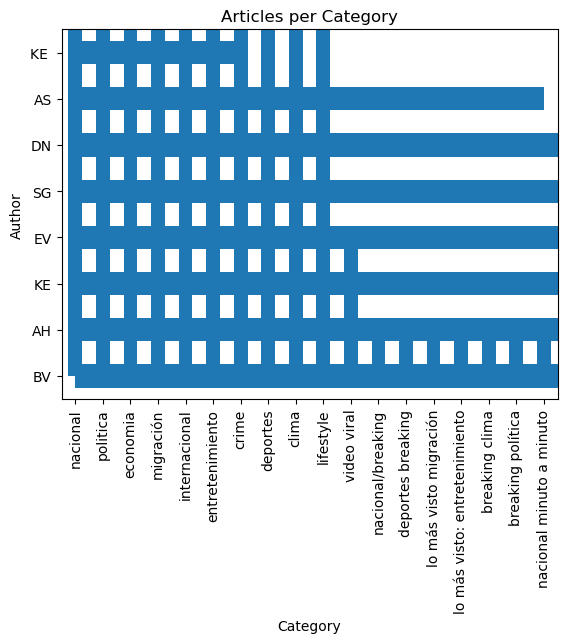

In [230]:
author_counts.head(10).plot(kind='barh', title='Top 10 Authors by Article Count')
category_counts.plot(kind='bar', title='Articles per Category')


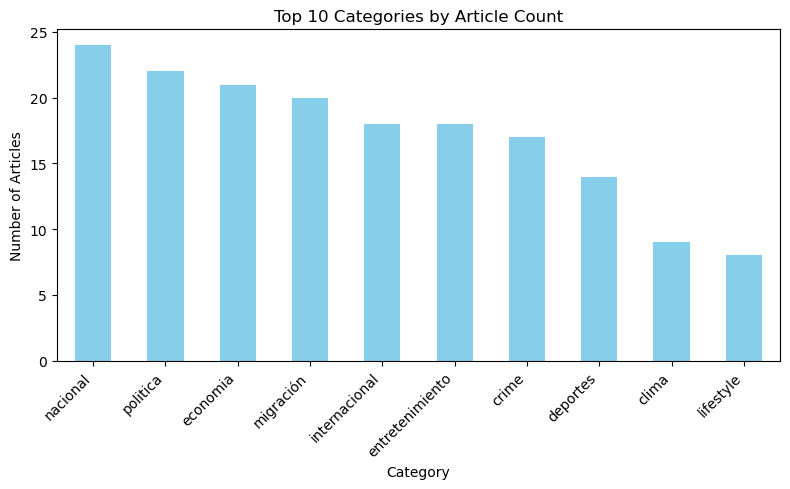

In [232]:
import matplotlib.pyplot as plt

top_categories = master_df['Category'].value_counts().head(10)
plt.figure(figsize=(8,5))
top_categories.plot(kind='bar', color='skyblue')
plt.title('Top 10 Categories by Article Count')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

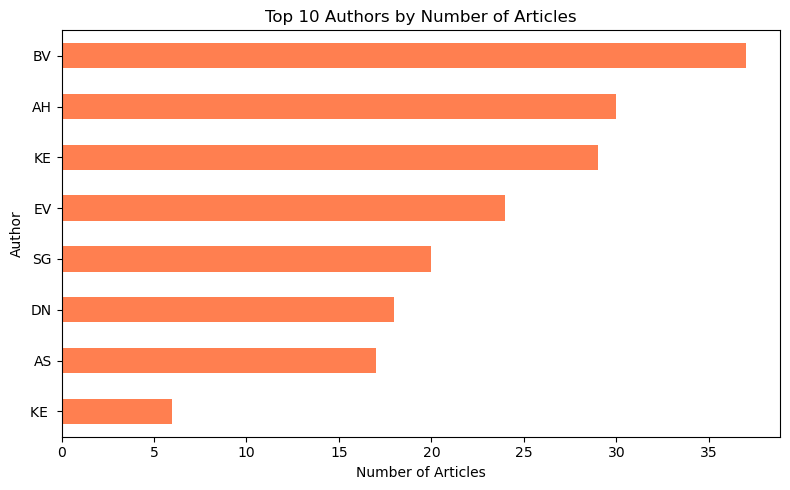

In [234]:
top_authors = master_df['Author'].value_counts().head(10)
plt.figure(figsize=(8,5))
top_authors.plot(kind='barh', color='coral')
plt.title('Top 10 Authors by Number of Articles')
plt.xlabel('Number of Articles')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Articles Published by Month'}, xlabel='Month'>

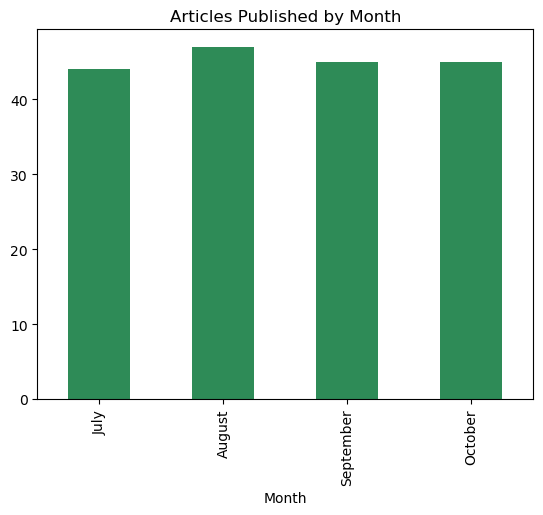

In [236]:
master_df['Month'] = master_df['Source_File'].str.extract(r'(\w+)\s2025')

monthly_counts = master_df['Month'].value_counts().reindex(['July','August','September','October'])
monthly_counts.plot(kind='bar', color='seagreen', title='Articles Published by Month')


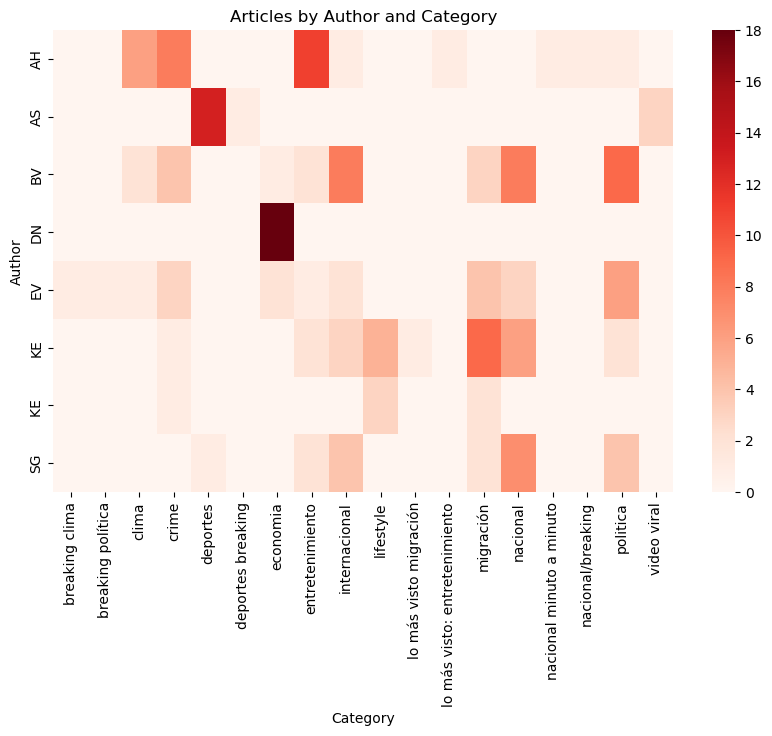

In [238]:
import seaborn as sns
cross_tab = pd.crosstab(master_df['Author'], master_df['Category'])
plt.figure(figsize=(10,6))
sns.heatmap(cross_tab, cmap='Reds')
plt.title('Articles by Author and Category')
plt.show()

In [240]:
pd.read_excel(full_path, header=1, usecols='A:H')


,Unnamed: 0,Unnamed: 1,FACEBOOK,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,CATEGORY,STORY HEADLINE (WORDPRESS),WRITER,SOURCE,POSTED,NaN,NaN
1,1.0,BREAKING CLIMA,Terremoto de 6.9 sacude Filipinas; deja decena...,EV,EFE,True,NaN,NaN
2,2.0,BREAKING POLÍTICA,El gobierno de Trump enfrenta un nuevo cierre ...,EV,EFE/USA Today,True,NaN,NaN
3,3.0,NACIONAL,Florida eleva su salario mínimo a 14 dólares ...,BV,EFE,True,NaN,NaN
4,4.0,POLÍTICA,Propuesta republicana para evitar cierre de Go...,EV,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...
61,NaN,NaN,Barcelona cae ante PSG en un duelo de Champion...,SG,NaN,NaN,NaN,NaN
62,NaN,NaN,Messi va por el récord de Carlos Vela en la MLS,AS,NaN,NaN,NaN,NaN
63,NaN,NaN,Dónde ver Real Madrid vs Villarreal EN VIVO,AS,NaN,NaN,NaN,NaN
64,NaN,NaN,Dónde ver Barcelona vs Sevilla EN VIVO,AS,NaN,NaN,NaN,NaN


In [242]:
# Step 1: Fix column names safely
rename_map = {}
for col in master_df.columns:
    if "CATEGORY" in str(col).upper():
        rename_map[col] = "Category"
    elif "HEADLINE" in str(col).upper():
        rename_map[col] = "Headline"
    elif "WRITER" in str(col).upper():
        rename_map[col] = "Writer"
    elif "SOURCE" in str(col).upper():
        rename_map[col] = "Source"
    elif "POSTED" in str(col).upper():
        rename_map[col] = "Posted"

master_df = master_df.rename(columns=rename_map)

# Step 2: Keep only the columns that actually exist
cols_to_keep = [c for c in ["Category", "Headline", "Writer", "Source", "Posted", "Source_File"] if c in master_df.columns]
master_df = master_df[cols_to_keep]

# Step 3: Drop blank rows (NaN)
master_df = master_df.dropna(subset=["Category", "Headline"])
master_df.head()


,Category,Headline,Source
0,politica,"La Casa Blanca dice sería ""difícil"" trabajar c...",Daily Tracking July 2025 (1).xlsx
1,nacional,Justicia de EE.UU. ordena al estado argentino ...,Daily Tracking July 2025 (1).xlsx
2,economia,La bolsa hoy: Wall Street abre julio con bajas...,Daily Tracking July 2025 (1).xlsx
3,migración,Juez ordena mantener en prisión al salvadoreñ...,Daily Tracking July 2025 (1).xlsx
4,internacional,Irán lanza fatwa contra Trump: lo declara “ene...,Daily Tracking July 2025 (1).xlsx


In [244]:
import re
import pandas as pd
import matplotlib.pyplot as plt

df = master_df.copy()

In [246]:

# 1) Normalize columns (works whether you renamed earlier or not)
rename_fallbacks = {
    r"^CATEGORY$": "Category",
    r"^STORY HEADLINE.*|^HEADLINE$|^FACEBOOK$": "Headline",
    r"^WRITER$|^AUTHOR$": "Author",
    r"^SOURCE FILE$|^SOURCE_FILE$|^SOURCEFILE$": "Source_File",
}
def norm_col(c):
    c = str(c).strip()
    for pat, rep in rename_fallbacks.items():
        if re.match(pat, c, flags=re.IGNORECASE):
            return rep
    return c

df.columns = [norm_col(c) for c in df.columns]

In [248]:
# 2) Keep just the useful columns that exist
cols = [c for c in ["Category","Headline","Author","Source_File"] if c in df.columns]
df = df[cols].dropna(subset=[c for c in ["Category","Headline"] if c in df.columns])
for c in cols:
    df[c] = df[c].astype(str).str.strip()


In [250]:
# 3) Derive Month from file name if available
if "Source_File" in df.columns:
    df["Month"] = df["Source_File"].str.extract(r'(July|August|September|October)\s+2025', expand=False)
else:
    df["Month"] = pd.NA

In [252]:
# 4) Core counts
by_cat = df["Category"].value_counts() if "Category" in df.columns else pd.Series(dtype=int)
by_author = df["Author"].value_counts() if "Author" in df.columns else pd.Series(dtype=int)
by_month = df["Month"].value_counts().reindex(["July","August","September","October"])

print("Rows:", len(df))
print("\nTop categories:\n", by_cat.head(10))
if not by_author.empty:
    print("\nTop authors:\n", by_author.head(10))
print("\nArticles by month:\n", by_month.dropna())

Rows: 181

Top categories:
 Category
nacional           24
politica           22
economia           21
migración          20
internacional      18
entretenimiento    18
crime              17
deportes           14
clima               9
lifestyle           8
Name: count, dtype: int64

Articles by month:
 Series([], Name: count, dtype: float64)


In [254]:
# 4) Core counts – safe version
by_cat = df["Category"].value_counts() if "Category" in df.columns else pd.Series(dtype=int)
by_author = df["Author"].value_counts() if "Author" in df.columns else pd.Series(dtype=int)
by_month = df["Month"].value_counts().reindex(["July", "August", "September", "October"]) if "Month" in df.columns else pd.Series(dtype=int)

print("Rows:", len(df))

if not by_cat.empty:
    print("\nTop categories:\n", by_cat.head(10))
else:
    print("\n⚠️  No 'Category' column found — check your header names with df.columns")

if not by_author.empty:
    print("\nTop authors:\n", by_author.head(10))
else:
    print("\n⚠️  No 'Author' column found — skipping author summary")

if not by_month.empty:
    print("\nArticles by month:\n", by_month.dropna())
else:
    print("\n⚠️  No 'Month' column found — skipping monthly summary")


Rows: 181

Top categories:
 Category
nacional           24
politica           22
economia           21
migración          20
internacional      18
entretenimiento    18
crime              17
deportes           14
clima               9
lifestyle           8
Name: count, dtype: int64

⚠️  No 'Author' column found — skipping author summary

Articles by month:
 Series([], Name: count, dtype: float64)


In [256]:
df = master_df.copy()
df = df[["Category","Headline","Source"]].rename(columns={"Source":"Source_File"})
df["Month"] = df["Source_File"].str.extract(r"(July|August|September|October)\s+2025", expand=False)
df.head()


,Category,Headline,Source_File,Month
0,politica,"La Casa Blanca dice sería ""difícil"" trabajar c...",Daily Tracking July 2025 (1).xlsx,July
1,nacional,Justicia de EE.UU. ordena al estado argentino ...,Daily Tracking July 2025 (1).xlsx,July
2,economia,La bolsa hoy: Wall Street abre julio con bajas...,Daily Tracking July 2025 (1).xlsx,July
3,migración,Juez ordena mantener en prisión al salvadoreñ...,Daily Tracking July 2025 (1).xlsx,July
4,internacional,Irán lanza fatwa contra Trump: lo declara “ene...,Daily Tracking July 2025 (1).xlsx,July


In [258]:
master_df.head()


,Category,Headline,Source
0,politica,"La Casa Blanca dice sería ""difícil"" trabajar c...",Daily Tracking July 2025 (1).xlsx
1,nacional,Justicia de EE.UU. ordena al estado argentino ...,Daily Tracking July 2025 (1).xlsx
2,economia,La bolsa hoy: Wall Street abre julio con bajas...,Daily Tracking July 2025 (1).xlsx
3,migración,Juez ordena mantener en prisión al salvadoreñ...,Daily Tracking July 2025 (1).xlsx
4,internacional,Irán lanza fatwa contra Trump: lo declara “ene...,Daily Tracking July 2025 (1).xlsx


In [260]:
# --- Derive Month from the Source file name ---
df = master_df.copy()
df["Month"] = df["Source"].str.extract(r"(July|August|September|October)\s+2025", expand=False)

# Quick check
print(df["Month"].value_counts())
df.head()


Month
August       47
September    45
October      45
July         44
Name: count, dtype: int64


,Category,Headline,Source,Month
0,politica,"La Casa Blanca dice sería ""difícil"" trabajar c...",Daily Tracking July 2025 (1).xlsx,July
1,nacional,Justicia de EE.UU. ordena al estado argentino ...,Daily Tracking July 2025 (1).xlsx,July
2,economia,La bolsa hoy: Wall Street abre julio con bajas...,Daily Tracking July 2025 (1).xlsx,July
3,migración,Juez ordena mantener en prisión al salvadoreñ...,Daily Tracking July 2025 (1).xlsx,July
4,internacional,Irán lanza fatwa contra Trump: lo declara “ene...,Daily Tracking July 2025 (1).xlsx,July


In [262]:
# counts you can report
by_cat   = df["Category"].value_counts()
by_month = df["Month"].value_counts().reindex(["July","August","September","October"])

print("Rows:", len(df))
print("\nTop categories:\n", by_cat.head(10))
print("\nArticles by month:\n", by_month.dropna())


Rows: 181

Top categories:
 Category
nacional           24
politica           22
economia           21
migración          20
internacional      18
entretenimiento    18
crime              17
deportes           14
clima               9
lifestyle           8
Name: count, dtype: int64

Articles by month:
 Month
July         44
August       47
September    45
October      45
Name: count, dtype: int64


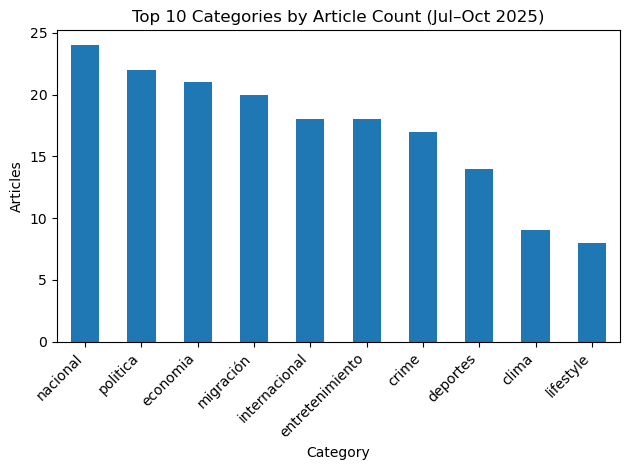

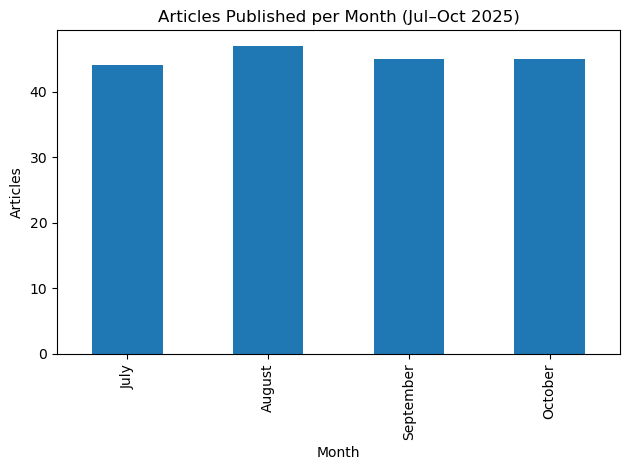

In [264]:
import matplotlib.pyplot as plt

# top categories
by_cat.head(10).plot(kind="bar")
plt.title("Top 10 Categories by Article Count (Jul–Oct 2025)")
plt.ylabel("Articles"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# monthly totals
by_month.plot(kind="bar")
plt.title("Articles Published per Month (Jul–Oct 2025)")
plt.ylabel("Articles"); plt.tight_layout(); plt.show()


In [266]:
cat_month = pd.crosstab(df["Category"], df["Month"]).reindex(columns=["July","August","September","October"]).fillna(0).astype(int)
cat_month.sort_values(["October","September","August","July"], ascending=False).head(15)


Month,July,August,September,October
Category,,,,
nacional,7,6,5,6
politica,6,5,5,6
migración,4,5,5,6
economia,4,7,5,5
entretenimiento,5,4,5,4
crime,5,4,4,4
deportes,3,3,4,4
internacional,5,5,5,3
lifestyle,2,2,2,2


Summary (Jul–Oct 2025)

Total articles: {{len(df)}}

Top categories (by volume): {list(by_cat.head(3).index)}

Publishing by month: {by_month.to_dict()}

Next: validate engagement (scroll depth) in GA and call out top/low performers by category and headline.

author_df   = read_ga_csv(r"C:\Users\spand\Downloads\PageAuthor.csv")
category_df = safe_read_csv(r"C:\Users\spand\Downloads\PageCategory.csv")
tag_df      = safe_read_csv(r"C:\Users\spand\Downloads\PageTag.csv")
scroll_df   = safe_read_csv(r"C:\Users\spand\Downloads\percent_scrolled.csv")
events_df   = safe_read_csv(r"C:\Users\spand\Downloads\Events.csv")
engage_df   = safe_read_csv(r"C:\Users\spand\Downloads\Engagement_overview.csv")



In [371]:
import pandas as pd
import chardet

def inspect_file(path):
    """Detect encoding and peek at first few lines."""
    with open(path, "rb") as f:
        raw = f.read(50000)
    enc = chardet.detect(raw)["encoding"]
    print(f"Detected encoding: {enc}")
    print("\nFirst 5 lines preview:")
    with open(path, "r", encoding=enc, errors="ignore") as f:
        for i in range(5):
            print(f.readline().strip())

# Example
inspect_file(r"C:\Users\spand\Downloads\PageAuthor.csv")


Detected encoding: utf-8

First 5 lines preview:
# ----------------------------------------
# Pages and screens: Page title and screen class
# Account: Mundo Now GA4
# Property: Mundo Now Nuevo GA4
# ----------------------------------------


In [373]:
import pandas as pd

def read_ga_csv(path):
    # Ignore lines starting with '#', auto-detect delimiter
    df = pd.read_csv(
        path,
        comment='#',          # <- ignores GA preamble lines
        sep=None,             # <- auto-detect delimiter
        engine='python',
        encoding='utf-8-sig', # <- handles BOM if present
        on_bad_lines='skip'
    )
    # normalize headers
    df.columns = (df.columns.str.strip().str.lower()
                  .str.replace(r'\s+', '_', regex=True)
                  .str.replace(r'[^\w]+', '_', regex=True)
                  .str.strip('_'))
    return df

author_df   = read_ga_csv(r"C:\Users\spand\Downloads\PageAuthor.csv")
category_df = read_ga_csv(r"C:\Users\spand\Downloads\PageCategory.csv")
tag_df      = read_ga_csv(r"C:\Users\spand\Downloads\PageTag.csv")
scroll_df   = read_ga_csv(r"C:\Users\spand\Downloads\percent_scrolled.csv")
events_df   = read_ga_csv(r"C:\Users\spand\Downloads\Events.csv")
engage_df   = read_ga_csv(r"C:\Users\spand\Downloads\Engagement_overview.csv")

for name, df in {
    "author": author_df, "category": category_df, "tag": tag_df,
    "scroll": scroll_df, "events": events_df, "engage": engage_df
}.items():
    print(f"\n{name} columns:", list(df.columns)[:10])
    print(df.head(2))



author columns: ['page_title_and_screen_class', 'pageauthor', 'views', 'active_users', 'views_per_active_user', 'average_engagement_time_per_active_user', 'event_count', 'key_events', 'total_revenue']
                         page_title_and_screen_class pageauthor  views  \
0  "El Charro" y La Mayrita hacen oficial su sepa...        NaN    2.0   
1       71 in bed: Learn about the alternative to 69        NaN    1.0   

   active_users  views_per_active_user  \
0           1.0                    2.0   
1           1.0                    1.0   

   average_engagement_time_per_active_user  event_count  key_events  \
0                                      0.0          8.0         4.0   
1                                     61.0          7.0         6.0   

   total_revenue  
0       0.001860  
1       0.001849  

category columns: ['page_title_and_screen_class', 'pagecategory', 'views', 'active_users', 'views_per_active_user', 'average_engagement_time_per_active_user', 'event_count', 'k

In [375]:
import pandas as pd
import numpy as np
import re

# base article table
base = master_df.copy()
keep = [c for c in ["Category","Headline","Month","Source"] if c in base.columns]
base = base[keep].dropna(subset=["Headline"]).copy()

# normalizer to match GA titles
def norm(s):
    s = str(s)
    s = s.replace('"','').replace("“","").replace("”","").replace("’","'").strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

base["key"] = base["Headline"].map(norm)
print("Base rows:", len(base))
base.head(3)


Base rows: 181


,Category,Headline,Source,key
0,politica,"La Casa Blanca dice sería ""difícil"" trabajar c...",Daily Tracking July 2025 (1).xlsx,la casa blanca dice sería difícil trabajar con...
1,nacional,Justicia de EE.UU. ordena al estado argentino ...,Daily Tracking July 2025 (1).xlsx,justicia de ee.uu. ordena al estado argentino ...
2,economia,La bolsa hoy: Wall Street abre julio con bajas...,Daily Tracking July 2025 (1).xlsx,la bolsa hoy: wall street abre julio con bajas...


In [377]:
title_col = "page_title_and_screen_class"

for df in [author_df, category_df, tag_df, scroll_df]:
    if title_col in df.columns:
        df["key"] = df[title_col].astype(str).map(lambda x: norm(x))
    else:
        raise ValueError(f"Expected column '{title_col}' not found in one GA file")

# sanity check
author_df.head(2), category_df.head(2), tag_df.head(2), scroll_df.head(2)


(                         page_title_and_screen_class pageauthor  views  \
 0  "El Charro" y La Mayrita hacen oficial su sepa...        NaN    2.0   
 1       71 in bed: Learn about the alternative to 69        NaN    1.0   
 
    active_users  views_per_active_user  \
 0           1.0                    2.0   
 1           1.0                    1.0   
 
    average_engagement_time_per_active_user  event_count  key_events  \
 0                                      0.0          8.0         4.0   
 1                                     61.0          7.0         6.0   
 
    total_revenue                                                key  
 0       0.001860  el charro y la mayrita hacen oficial su separa...  
 1       0.001849       71 in bed: learn about the alternative to 69  ,
                          page_title_and_screen_class pagecategory  views  \
 0  "El Charro" y La Mayrita hacen oficial su sepa...          NaN    7.0   
 1  30 marcas que usan Animal Testing, sus product...   

In [379]:
# columns we care about from tag export (keep if present)
ga_metric_cols = [c for c in [
    "views","active_users","views_per_active_user",
    "average_engagement_time_per_active_user",
    "event_count","key_events","total_revenue"
] if c in tag_df.columns]

ga_base = tag_df[["key"] + ga_metric_cols].copy()
merged = base.merge(ga_base, on="key", how="left")

print("Merged (base+GA) shape:", merged.shape)
merged.head(3)


Merged (base+GA) shape: (198, 11)


,Category,Headline,Source,key,views,active_users,views_per_active_user,average_engagement_time_per_active_user,event_count,key_events,total_revenue
0,politica,"La Casa Blanca dice sería ""difícil"" trabajar c...",Daily Tracking July 2025 (1).xlsx,la casa blanca dice sería difícil trabajar con...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nacional,Justicia de EE.UU. ordena al estado argentino ...,Daily Tracking July 2025 (1).xlsx,justicia de ee.uu. ordena al estado argentino ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,economia,La bolsa hoy: Wall Street abre julio con bajas...,Daily Tracking July 2025 (1).xlsx,la bolsa hoy: wall street abre julio con bajas...,18.0,9.0,2.0,0.0,30.0,18.0,0.0


In [381]:
# safe pickers if columns exist
auth_col = "pageauthor" if "pageauthor" in author_df.columns else None
catg_col = "pagecategory" if "pagecategory" in category_df.columns else None
tagg_col = "pagetag" if "pagetag" in tag_df.columns else None  # note: tag already used for metrics; this is just label

if auth_col:
    merged = merged.merge(author_df[["key", auth_col]], on="key", how="left")
if catg_col and catg_col not in merged.columns:
    merged = merged.merge(category_df[["key", catg_col]], on="key", how="left")
if tagg_col and tagg_col not in merged.columns:
    merged = merged.merge(tag_df[["key", tagg_col]], on="key", how="left", suffixes=("", "_from_tagfile"))

# prefer editorial Category if you have both GA and editorial
merged["Category_final"] = merged["Category"]
if catg_col in merged.columns:
    merged["Category_final"] = merged["Category_final"].fillna(merged[catg_col])

# nice alias
merged = merged.rename(columns={auth_col: "Author_GA", catg_col: "Category_GA", tagg_col: "Tag_GA"})
print("Columns now:", list(merged.columns)[:15])
merged.head(3)


Columns now: ['Category', 'Headline', 'Source', 'key', 'views', 'active_users', 'views_per_active_user', 'average_engagement_time_per_active_user', 'event_count', 'key_events', 'total_revenue', 'Author_GA', 'Category_GA', 'Tag_GA', 'Category_final']


,Category,Headline,Source,key,views,active_users,views_per_active_user,average_engagement_time_per_active_user,event_count,key_events,total_revenue,Author_GA,Category_GA,Tag_GA,Category_final
0,politica,"La Casa Blanca dice sería ""difícil"" trabajar c...",Daily Tracking July 2025 (1).xlsx,la casa blanca dice sería difícil trabajar con...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,politica
1,nacional,Justicia de EE.UU. ordena al estado argentino ...,Daily Tracking July 2025 (1).xlsx,justicia de ee.uu. ordena al estado argentino ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nacional
2,economia,La bolsa hoy: Wall Street abre julio con bajas...,Daily Tracking July 2025 (1).xlsx,la bolsa hoy: wall street abre julio con bajas...,18.0,9.0,2.0,0.0,30.0,18.0,0.0,(not set),(not set),(not set),economia


In [383]:
# Keep only rows with percent_scrolled & key
scroll_cols = [c for c in ["key","percent_scrolled","event_count"] if c in scroll_df.columns]
scroll_clean = scroll_df[scroll_cols].dropna(subset=["percent_scrolled","key"]).copy()

# make percent_scrolled numeric (25/50/75/100)
scroll_clean["percent_scrolled"] = pd.to_numeric(scroll_clean["percent_scrolled"], errors="coerce")
scroll_clean = scroll_clean.dropna(subset=["percent_scrolled"])

# event_count numeric
if "event_count" in scroll_clean.columns:
    scroll_clean["event_count"] = pd.to_numeric(scroll_clean["event_count"], errors="coerce").fillna(0)
else:
    scroll_clean["event_count"] = 0

# pivot to columns: scroll_25, scroll_50, scroll_75, scroll_100 (event counts)
scroll_pivot = (scroll_clean
                .groupby(["key","percent_scrolled"])["event_count"].sum()
                .unstack(fill_value=0)
                .rename(columns=lambda x: f"scroll_{int(x)}"))

# add totals & proportions
scroll_pivot["scroll_total"] = scroll_pivot.sum(axis=1)
for p in [25,50,75,100]:
    col = f"scroll_{p}"
    if col in scroll_pivot.columns:
        scroll_pivot[f"{col}_pct"] = np.where(scroll_pivot["scroll_total"]>0,
                                              scroll_pivot[col]/scroll_pivot["scroll_total"], np.nan)

merged = merged.merge(scroll_pivot.reset_index(), on="key", how="left")

print("After scroll merge:", merged.shape)
merged.head(3)


After scroll merge: (409, 25)


,Category,Headline,Source,key,views,active_users,views_per_active_user,average_engagement_time_per_active_user,event_count,key_events,...,scroll_25,scroll_50,scroll_75,scroll_90,scroll_100,scroll_total,scroll_25_pct,scroll_50_pct,scroll_75_pct,scroll_100_pct
0,politica,"La Casa Blanca dice sería ""difícil"" trabajar c...",Daily Tracking July 2025 (1).xlsx,la casa blanca dice sería difícil trabajar con...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nacional,Justicia de EE.UU. ordena al estado argentino ...,Daily Tracking July 2025 (1).xlsx,justicia de ee.uu. ordena al estado argentino ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,economia,La bolsa hoy: Wall Street abre julio con bajas...,Daily Tracking July 2025 (1).xlsx,la bolsa hoy: wall street abre julio con bajas...,18.0,9.0,2.0,0.0,30.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [385]:
# Overall counts
print("Articles in scope:", len(merged))
print("With any GA Views:", merged["views"].gt(0).sum() if "views" in merged.columns else "N/A")

# Category performance
metrics = [m for m in ["views","average_engagement_time_per_active_user"] if m in merged.columns]
if metrics:
    cat_perf = (merged.groupby("Category_final")[metrics]
                .mean()
                .sort_values(metrics[0], ascending=False)
                .head(10))
    print("\nTop categories by", metrics[0], ":\n", cat_perf)

# Author performance (from GA author if present)
if "Author_GA" in merged.columns:
    auth_perf = (merged.dropna(subset=["Author_GA"])
                 .groupby("Author_GA")[metrics]
                 .mean()
                 .sort_values(metrics[0], ascending=False)
                 .head(10))
    print("\nTop authors by", metrics[0], ":\n", auth_perf)

# Scroll-depth distribution (across all articles)
scroll_dist_cols = [c for c in ["scroll_25","scroll_50","scroll_75","scroll_100"] if c in merged.columns]
if scroll_dist_cols:
    total_scroll = merged[scroll_dist_cols].sum()
    print("\nScroll depth totals (event counts):\n", total_scroll)

# Optimization list: high views but low 100%-scroll share
if "views" in merged.columns and "scroll_100_pct" in merged.columns:
    med_views = merged["views"].median()
    med_full  = merged["scroll_100_pct"].median(skipna=True)
    optimize = (merged[(merged["views"] >= med_views) & (merged["scroll_100_pct"] < med_full)]
                .sort_values("views", ascending=False)
                .loc[:, ["Headline","Category_final","views","average_engagement_time_per_active_user","scroll_100_pct"]]
                .head(15))
    print("\nHigh views + low full-scroll (optimize):\n", optimize)


Articles in scope: 409
With any GA Views: 149

Top categories by views :
                        views  average_engagement_time_per_active_user
Category_final                                                       
migración        1365.107692                                 9.114510
crime            1097.875000                                 5.198311
internacional     754.864198                                 8.209521
nacional          526.400000                                 9.755483
video viral       198.315789                                 4.427705
politica          168.782609                                 8.377114
entretenimiento   103.333333                                 6.768390
deportes           99.611111                                 1.370022
lifestyle          47.000000                                 4.447368
economia           27.454545                                13.923975

Top authors by views :
                              views  average_engagement_time_p

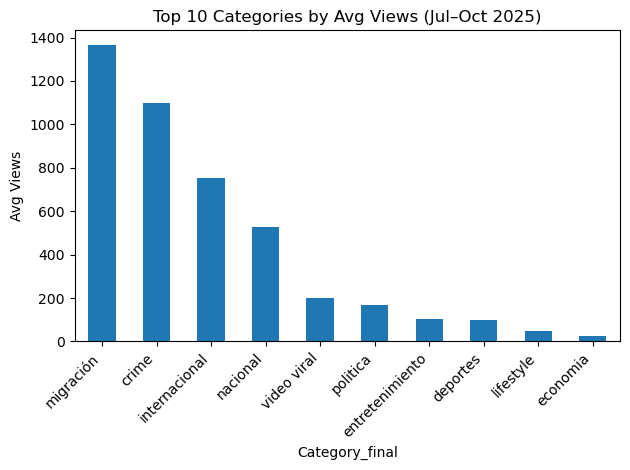

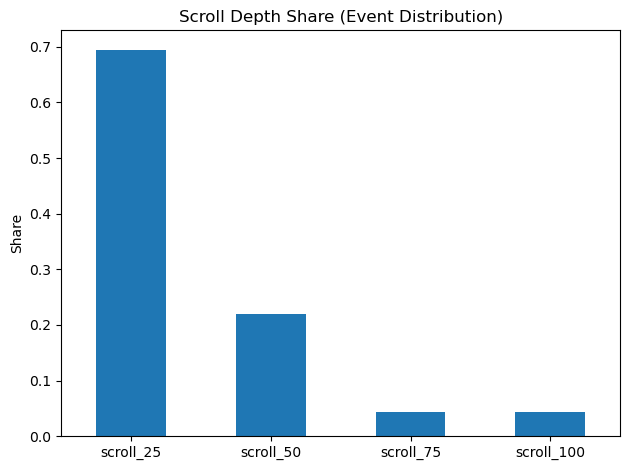

In [387]:
import matplotlib.pyplot as plt

# Top 10 categories by views
if metrics and "Category_final" in merged.columns:
    cat_views = merged.groupby("Category_final")["views"].mean().sort_values(ascending=False).head(10)
    cat_views.plot(kind="bar")
    plt.title("Top 10 Categories by Avg Views (Jul–Oct 2025)")
    plt.ylabel("Avg Views"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# Scroll depth shares overall
if all(c in merged.columns for c in ["scroll_25","scroll_50","scroll_75","scroll_100"]):
    total = merged[["scroll_25","scroll_50","scroll_75","scroll_100"]].sum()
    (total / total.sum()).plot(kind="bar")
    plt.title("Scroll Depth Share (Event Distribution)")
    plt.ylabel("Share"); plt.xticks(rotation=0); plt.tight_layout(); plt.show()


Summary – Editorial Engagement (Jul–Oct 2025)

Articles analyzed: {{len(merged)}}

Top categories by avg views: (show top 3 from cat_perf)

Authors with strongest avg views/engagement: (top 3 from auth_perf)

Scroll behavior: Overall distribution across 25/50/75/100 shows {{round((total/total.sum()),2).to_dict()}}; categories X/Y retain more readers to 75–100%.

Optimization list: 10–15 high-view articles with low 100%-scroll (test shorter intros, subheads, image placement, or paragraph spacing).

Total articles: 261
With GA views: 95

Top Categories by Avg Views:
 Category
crime              1097.875000
migración          1004.242424
internacional       652.000000
nacional            424.000000
video viral         212.000000
politica            135.600000
entretenimiento     103.333333
deportes             85.875000
lifestyle            47.000000
economia             27.454545
Name: views, dtype: float64

Top Authors by Avg Views:
 pageauthor
Santiago Guevara         928.444444
Kristel Escobar          477.500000
(not set)                420.320388
Bryan Vargas Martinez    246.000000
Alfredo Suárez           174.000000
MundoNOW                   3.000000
Name: views, dtype: float64

Scroll Depth Distribution (total events):
 scroll_100     188.0
scroll_25     2915.0
scroll_50      792.0
scroll_75      188.0
scroll_90      188.0
dtype: float64


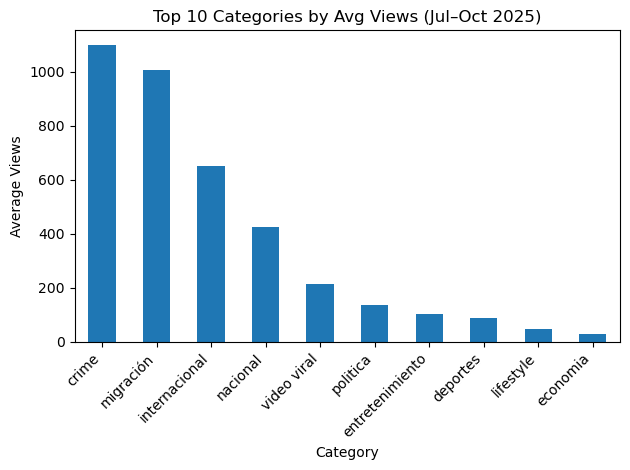

In [389]:
import numpy as np
import re
import matplotlib.pyplot as plt

# 1️⃣ Clean your editorial dataset
base = master_df.copy()
keep = [c for c in ["Category","Headline","Month","Source"] if c in base.columns]
base = base[keep].dropna(subset=["Headline"]).copy()

def norm(s):
    s = str(s).lower().strip().replace('"','').replace("“","").replace("”","")
    s = re.sub(r"\s+", " ", s)
    return s

base["key"] = base["Headline"].map(norm)

# 2️⃣ Prepare GA datasets with key
title_col = "page_title_and_screen_class"
for df in [author_df, category_df, tag_df, scroll_df]:
    df["key"] = df[title_col].astype(str).map(norm)

# 3️⃣ Merge Tag metrics
ga_metrics = [c for c in ["views","average_engagement_time_per_active_user",
                          "active_users","event_count","key_events"] if c in tag_df.columns]
ga_tag = tag_df[["key"] + ga_metrics].copy()
merged = base.merge(ga_tag, on="key", how="left")

# 4️⃣ Add author/category from GA
merged = merged.merge(author_df[["key","pageauthor"]], on="key", how="left")
merged = merged.merge(category_df[["key","pagecategory"]], on="key", how="left")

# 5️⃣ Merge scroll depth
scroll_clean = scroll_df[["key","percent_scrolled","event_count"]].dropna()
scroll_clean["percent_scrolled"] = pd.to_numeric(scroll_clean["percent_scrolled"], errors="coerce")
scroll_pivot = (scroll_clean.groupby(["key","percent_scrolled"])["event_count"]
                .sum().unstack(fill_value=0)
                .rename(columns=lambda x: f"scroll_{int(x)}"))
merged = merged.merge(scroll_pivot.reset_index(), on="key", how="left")

# 6️⃣ Insights
print("Total articles:", len(merged))
print("With GA views:", merged["views"].gt(0).sum())

# Category performance
cat_perf = (merged.groupby("Category")["views"]
            .mean().sort_values(ascending=False).head(10))
print("\nTop Categories by Avg Views:\n", cat_perf)

# Author performance
auth_perf = (merged.groupby("pageauthor")["views"]
             .mean().sort_values(ascending=False).head(10))
print("\nTop Authors by Avg Views:\n", auth_perf)

# Scroll-depth overview
scroll_cols = [c for c in merged.columns if c.startswith("scroll_") and not c.endswith("_pct")]
if scroll_cols:
    total_scroll = merged[scroll_cols].sum().sort_index()
    print("\nScroll Depth Distribution (total events):\n", total_scroll)

# 7️⃣ Quick chart
cat_perf.plot(kind="bar", title="Top 10 Categories by Avg Views (Jul–Oct 2025)")
plt.ylabel("Average Views")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [391]:
master_df.to_csv("MundoNow_Cleaned_Data.csv", index=False, encoding='utf-8-sig')


In [393]:
import pandas as pd
from functools import reduce

# ✅ 1. Define your file paths (update if your filenames differ)
author_path   = r"C:\Users\spand\Downloads\PageAuthor.csv"
category_path = r"C:\Users\spand\Downloads\PageCategory.csv"
tag_path      = r"C:\Users\spand\Downloads\PageTag.csv"
scroll_path   = r"C:\Users\spand\Downloads\percent_scrolled.csv"
events_path   = r"C:\Users\spand\Downloads\Events.csv"
engage_path   = r"C:\Users\spand\Downloads\Engagement_overview.csv"

# ✅ 2. Read each CSV safely
def load_csv(path):
    return pd.read_csv(path, encoding="utf-8-sig", on_bad_lines="skip")

author_df   = load_csv(author_path)
category_df = load_csv(category_path)
tag_df      = load_csv(tag_path)
scroll_df   = load_csv(scroll_path)
events_df   = load_csv(events_path)
engage_df   = load_csv(engage_path)

# ✅ 3. Normalize column names
for df in [author_df, category_df, tag_df, scroll_df, events_df, engage_df]:
    df.columns = df.columns.str.strip().str.lower().str.replace(r'\s+', '_', regex=True)

# ✅ 4. Merge key tables (matching by page_title_and_screen_class)
dfs_to_merge = [author_df, category_df, tag_df, scroll_df]
merged_df = reduce(lambda left, right: pd.merge(
    left, right, on="page_title_and_screen_class", how="outer"
), dfs_to_merge)

# ✅ 5. Add engagement metrics (average_engagement_time, event_count)
merged_df["avg_engagement_time"] = engage_df["average_engagement_time_per_active_user"].mean()
merged_df["total_event_count"] = events_df["event_count"].sum()

# ✅ 6. Clean up (fill NAs, remove duplicates)
merged_df = merged_df.fillna(0).drop_duplicates(subset=["page_title_and_screen_class"])

# ✅ 7. Save cleaned file for Looker Studio
output_path = r"C:\Users\spand\Downloads\MundoNow_Cleaned_Data.csv"
merged_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ Merged CSV created successfully: {output_path}")
print(f"Shape: {merged_df.shape}")
print("Columns:", merged_df.columns.tolist())


KeyError: 'page_title_and_screen_class'